## Import Libraries

In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

REBUILD_DATA = False

# Loading image as training data
class DogsVsCats():
    IMG_SIZE = 50 # make image 50 x 50
    CATS = "CatsAndDogs/PetImages/Cat"
    DOGS = "CatsAndDogs/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    cat_count = 0
    dog_count = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)): # for file in directory
                try:
                    path = os.path.join(label, f) # path to file
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # read image and convert to gray scale
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE)) # resize image
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) # [image, one hot label]

                    # make sure count of cats and dogs are roughly the same
                    if label == self.CATS:
                        self.cat_count += 1
                    elif label == self.DOGS:
                        self.dog_count += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.cat_count)
        print("Dogs: ", self.dog_count)
        
if REBUILD_DATA:
    dogsvscats = DogsVsCats()
    dogsvscats.make_training_data()

In [2]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [3]:
print(len(training_data))

24946


[1. 0.]


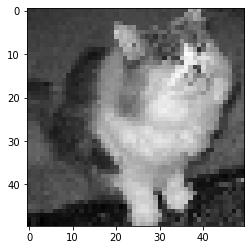

In [5]:
print(training_data[1][1]) # [1, 0] for cat
plt.imshow(training_data[1][0], cmap="gray")

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # (input size, output size, kernel size)
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        self.fc1 = nn.Linear(128 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = F.relu(self.fc1(x.view(-1, 128 * 2 * 2)))
        x = F.softmax(self.fc2(x), dim=1)
        return x
    
    def get_size(self):
        # Get the shape of input after last layer of convolution
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        x = self.convs(x)
        print(x[0].shape)

In [25]:
net = Net()

In [27]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [28]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0 # Normalize value
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size) # percentage of the training data

2494


In [38]:
# Split into training and testing data
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [41]:
BATCH_SIZE = 100
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i: i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i: i + BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    print(loss)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.2060, grad_fn=<MseLossBackward>)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.1720, grad_fn=<MseLossBackward>)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.1541, grad_fn=<MseLossBackward>)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.1267, grad_fn=<MseLossBackward>)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.1131, grad_fn=<MseLossBackward>)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.1008, grad_fn=<MseLossBackward>)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.0968, grad_fn=<MseLossBackward>)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.0790, grad_fn=<MseLossBackward>)


  0%|                                                                             | 0/225 [00:00<?, ?it/s]

tensor(0.0570, grad_fn=<MseLossBackward>)


100%|███████████████████████████████████████████████████████████████████| 225/225 [00:51<00:00,  4.34it/s]

tensor(0.0687, grad_fn=<MseLossBackward>)


In [42]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy: ", round(correct/total, 3))

100%|████████████████████████████████████████████████████████████████| 2494/2494 [00:03<00:00, 643.45it/s]

Accuracy:  0.783
